In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


# Load Dataset extracted from BigQuery
file_path = "/home/nsmsc/merged_instance_usage_200k - new.csv"
data = pd.read_csv(file_path)

# Convert start and end times from microseconds to seconds
data['start_time'] = data['start_time'] / 1e6
data['end_time'] = data['end_time'] / 1e6

# Sort data by start time
data = data.sort_values(by='start_time')

# Define the interval length 
interval_length = 300

def process_interval(interval_data):
    collection_id_counts = interval_data['collection_id'].value_counts()
    non_unique_collection_ids_count = collection_id_counts[collection_id_counts > 1].count()
    unique_collection_ids_count = interval_data['collection_id'].nunique()
    unique_machine_ids_count = interval_data['machine_id'].nunique()
    sum_avg_cpu = interval_data['average_usage.cpus'].sum()
    sum_avg_memory = interval_data['average_usage.memory'].sum()
    sum_max_cpu = interval_data['maximum_usage.cpus'].sum()
    sum_max_memory = interval_data['maximum_usage.memory'].sum()

    return {
        'start_time': interval_data['start_time'].min(),
        'unique_collection_ids': unique_collection_ids_count,
        'non_unique_collection_ids': non_unique_collection_ids_count,
        'unique_machine_ids': unique_machine_ids_count,
        'sum_avg_cpu': sum_avg_cpu,
        'sum_avg_memory': sum_avg_memory,
        'sum_max_cpu': sum_max_cpu,
        'sum_max_memory': sum_max_memory
    }

def prepare_features(data):
    results = []
    start_time = data['start_time'].min()
    end_time = data['start_time'].max()

    current_start = start_time

    while current_start < end_time:
        current_end = current_start + interval_length
        interval_data = data[(data['start_time'] >= current_start) & (data['start_time'] < current_end)]
        if not interval_data.empty:
            interval_result = process_interval(interval_data)
            results.append(interval_result)
        current_start = current_end

    df = pd.DataFrame(results)
    df = df.dropna().reset_index(drop=True)

    return df

# Split the data into 70% training and 30% testing
train_data, test_data = train_test_split(data, test_size=0.3, shuffle=False)


train_features = prepare_features(train_data)

# Prepare features for the testing data (untouched raw data for prediction)
test_features = prepare_features(test_data)  # For prediction


X_train = train_features.drop(columns=['sum_avg_cpu', 'sum_avg_memory', 'sum_max_cpu', 'sum_max_memory', 'start_time'])
y_train = train_features[['sum_avg_cpu', 'sum_avg_memory', 'sum_max_cpu', 'sum_max_memory']]

# Initialize XGBoost model
models = {}
for target in y_train.columns:
    models[target] = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')
    models[target].fit(X_train, y_train[target])


X_test = test_features.drop(columns=['sum_avg_cpu', 'sum_avg_memory', 'sum_max_cpu', 'sum_max_memory', 'start_time'])
y_test = test_features[['sum_avg_cpu', 'sum_avg_memory', 'sum_max_cpu', 'sum_max_memory']]


y_pred = pd.DataFrame()
for target in y_test.columns:
    y_pred[target] = models[target].predict(X_test)


for target in y_test.columns:
    mse = mean_squared_error(y_test[target], y_pred[target])
    print(f"Mean Squared Error for {target}: {mse}")

# Optionally, create a DataFrame to compare predictions with actual values
result_df = pd.concat([test_features.reset_index(drop=True), y_pred.add_suffix('_pred')], axis=1)
print(result_df.head())




/home/nsmsc/.local/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


Mean Squared Error for sum_avg_cpu: 0.005072429847124342
Mean Squared Error for sum_avg_memory: 0.0011929592964028553
Mean Squared Error for sum_max_cpu: 0.07890148763912756
Mean Squared Error for sum_max_memory: 0.0015111244651770577
   start_time  unique_collection_ids  non_unique_collection_ids  \
0   1884000.0                      4                          0   
1   1884300.0                     16                          0   
2   1884600.0                     17                          2   
3   1884900.0                     12                          0   
4   1885200.0                     20                          2   

   unique_machine_ids  sum_avg_cpu  sum_avg_memory  sum_max_cpu  \
0                   4     0.003046        0.002594     0.020234   
1                  16     0.061347        0.057535     0.297517   
2                  19     0.141060        0.108654     0.458962   
3                  12     0.042142        0.040916     0.194399   
4                  22     0

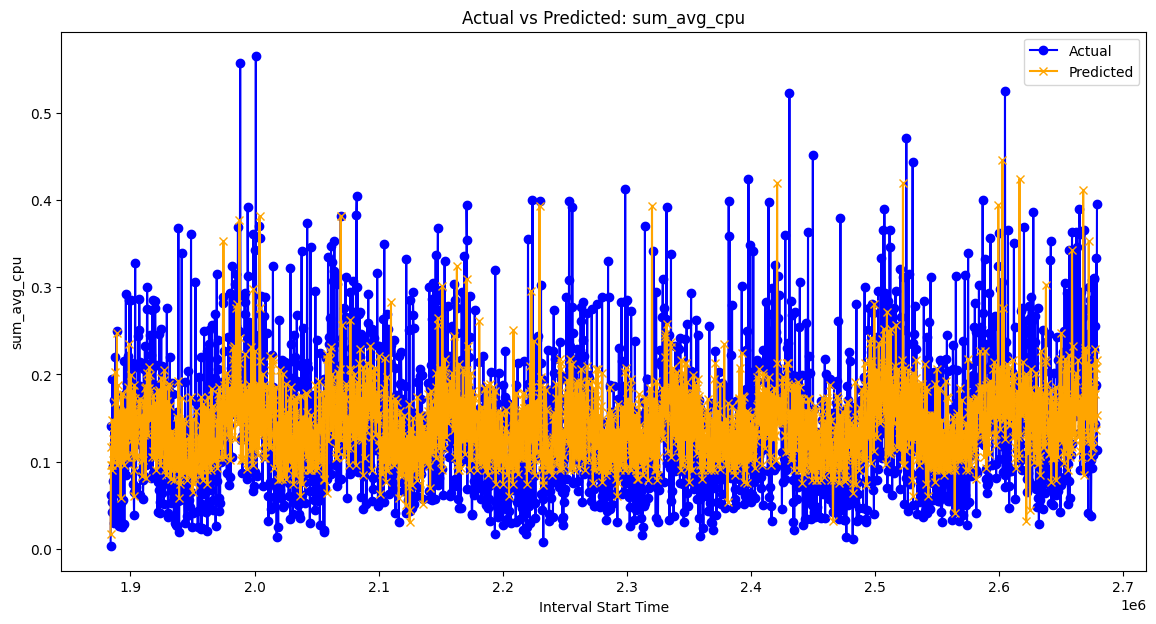

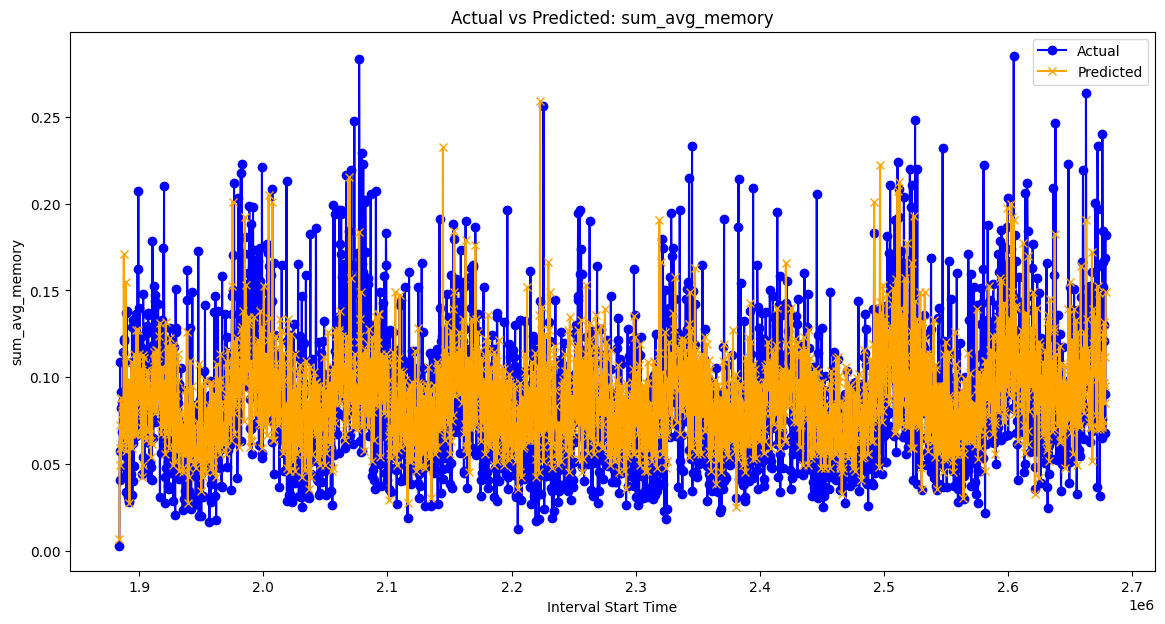

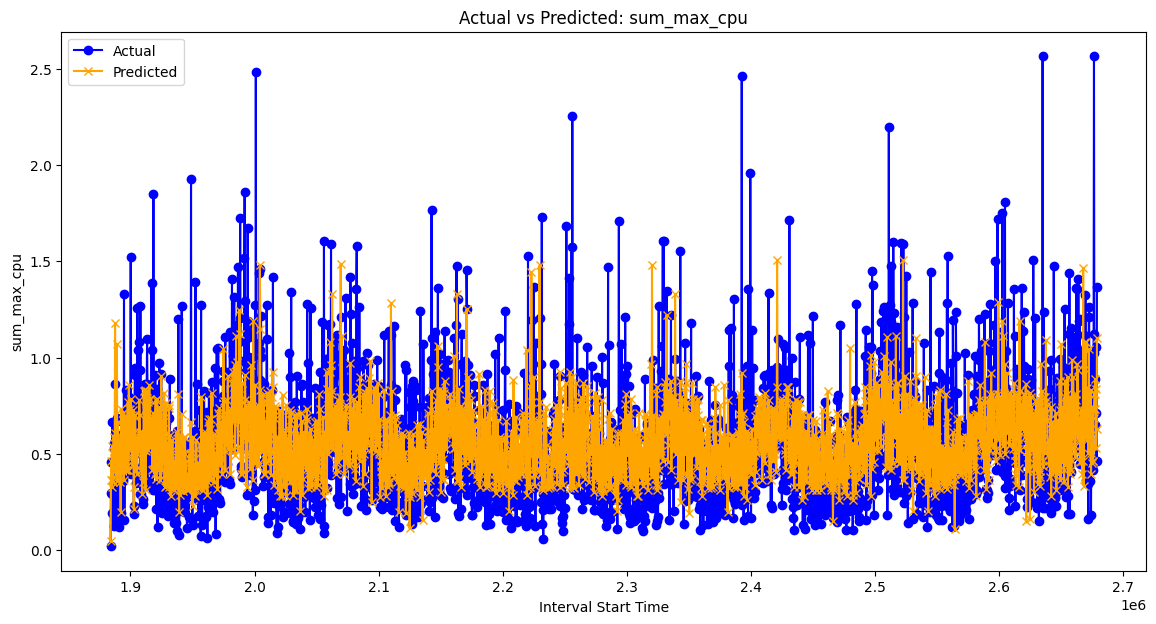

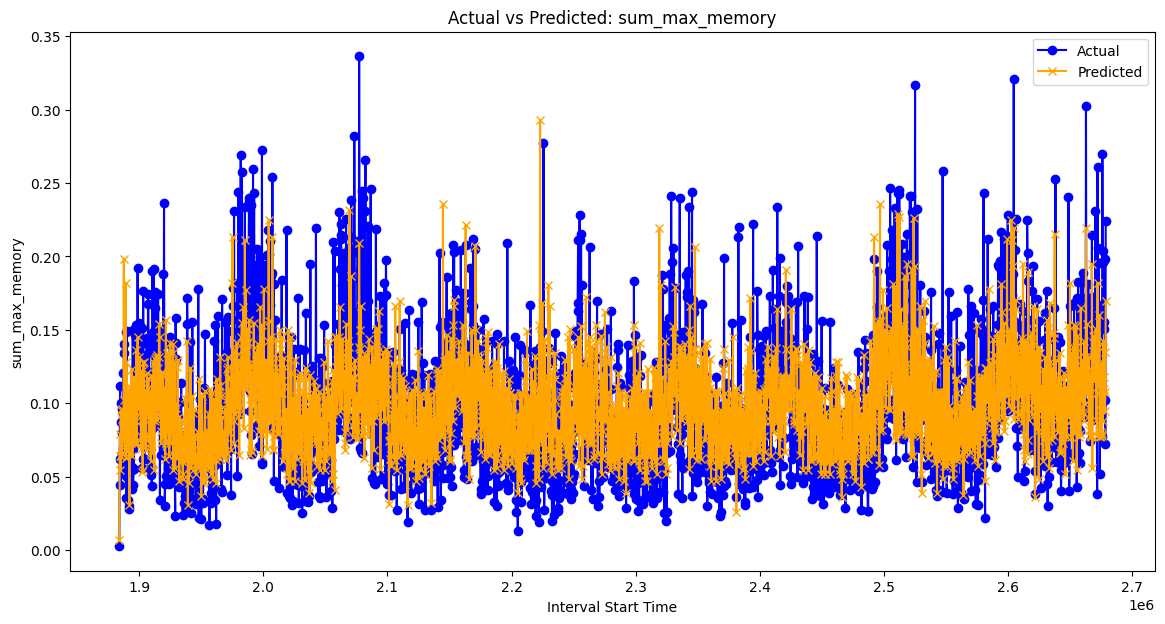

In [2]:
import matplotlib.pyplot as plt


def plot_actual_vs_predicted(result_df, actual_col, predicted_col, interval_col):
    plt.figure(figsize=(14, 7))
    plt.plot(result_df[interval_col], result_df[actual_col], label='Actual', marker='o', color='blue')
    plt.plot(result_df[interval_col], result_df[predicted_col], label='Predicted', marker='x', color='orange')
    plt.title(f'Actual vs Predicted: {actual_col}')
    plt.xlabel('Interval Start Time')
    plt.ylabel(actual_col)
    plt.legend()
    plt.show()

plot_actual_vs_predicted(result_df, 'sum_avg_cpu', 'sum_avg_cpu_pred', 'start_time')
plot_actual_vs_predicted(result_df, 'sum_avg_memory', 'sum_avg_memory_pred', 'start_time')
plot_actual_vs_predicted(result_df, 'sum_max_cpu', 'sum_max_cpu_pred', 'start_time')
plot_actual_vs_predicted(result_df, 'sum_max_memory', 'sum_max_memory_pred', 'start_time')


In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def calculate_metrics(y_true, y_pred):
    # Mean Squared Error (MSE)
    mse = mean_squared_error(y_true, y_pred)
    
    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    
    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)
    
    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    # Accuracy Percentage
    accuracy = 100 - mape
    
    return mse, rmse, mae, mape, accuracy

e
metrics = {}
for target in y_test.columns:
    mse, rmse, mae, mape, accuracy = calculate_metrics(y_test[target], y_pred[target])
    metrics[target] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'Accuracy (%)': accuracy
    }


for target, metric_values in metrics.items():
    print(f"Metrics for {target}:")
    for metric_name, value in metric_values.items():
        print(f"  {metric_name}: {value}")
    print("\n")


Metrics for sum_avg_cpu:
  MSE: 0.005072429847124342
  RMSE: 0.07122099302259371
  MAE: 0.05397454273190257
  MAPE: 50.80170260217801
  Accuracy (%): 49.19829739782199


Metrics for sum_avg_memory:
  MSE: 0.0011929592964028553
  RMSE: 0.03453924284640379
  MAE: 0.026195538347968807
  MAPE: 34.654216467085405
  Accuracy (%): 65.3457835329146


Metrics for sum_max_cpu:
  MSE: 0.07890148763912756
  RMSE: 0.2808940861590496
  MAE: 0.20662366284782246
  MAPE: 47.11496678327454
  Accuracy (%): 52.88503321672546


Metrics for sum_max_memory:
  MSE: 0.0015111244651770577
  RMSE: 0.038873184397178705
  MAE: 0.029547612297581342
  MAPE: 34.3407259501504
  Accuracy (%): 65.6592740498496


